In [11]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
from skimage import exposure

In [4]:
# CUSTOM_MODEL_NAME = "ssd_mobilenet_fpn_640x640"
CUSTOM_MODEL_NAME = "ssd_resnet50_v1_fpn_640x640"
PATHS = {
    "DATASET":os.path.join(".", "datasets", "v0"),
    "APIMODEL": os.path.join(".", "apimodel"),
    "PROTOC": os.path.join(".", "protoc"),
    "CUSTOM_MODELS": os.path.join(".", "custom_models"),
    "CUSTOM_MODEL": os.path.join(".", "custom_models", CUSTOM_MODEL_NAME),
}
PATH_DATASET = PATHS["DATASET"]
PATH_APIMODEL = PATHS["APIMODEL"]
PATH_PROTOC = PATHS["PROTOC"]
PATH_CUSTOM_MODELS = PATHS["CUSTOM_MODELS"]
PATH_CUSTOM_MODEL = PATHS["CUSTOM_MODEL"]
PATH_PIPELINE_CONFIG = os.path.join(PATH_CUSTOM_MODEL, 'pipeline.config')

In [5]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_PIPELINE_CONFIG)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_CUSTOM_MODEL, 'ckpt-30')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

2024-01-22 10:53:19.449874: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-22 10:53:19.478020: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-22 10:53:19.478089: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-22 10:53:19.480109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-22 10:53:19.480168: I tensorflow/compile

In [6]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
path_label = os.path.abspath(os.path.join(PATH_DATASET, 'train', 'FDM-defects_label_map.pbtxt'))
category_index = label_map_util.create_category_index_from_labelmap(path_label)

In [27]:
# IMAGE_PATH = str(os.path.join(".", "datasets", "spaghetti_55.jpg"))
# IMAGE_PATH = str(os.path.join(".", "datasets", "4 (3).jpg"))
# IMAGE_PATH = str(os.path.join(".", "datasets", "20240121_224428.jpg"))
IMAGE_PATH = str(os.path.join(".", "datasets", "20240121_235223.jpg"))
# IMAGE_PATH = str(os.path.join(".", "datasets", "20240121_235131.jpg"))

In [28]:
img = cv2.imread(IMAGE_PATH)
resized = cv2.resize(img, (640,640), interpolation = cv2.INTER_AREA)
image_np = np.array(resized)
img_adapteq = exposure.equalize_adapthist(image_np, clip_limit=0.03)
img_adapteq_2 = (img_adapteq*255.).astype(np.uint8)

100


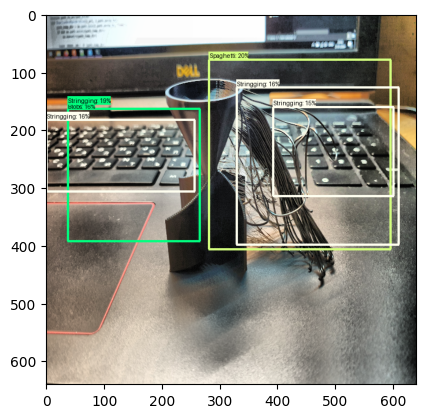

In [29]:
image_np =img_adapteq_2
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
print(f"{num_detections}")
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.1,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()